<a href="https://colab.research.google.com/github/ninda-code/ecommerce-review-sentiments/blob/main/text_analytics_playground.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Women ecommerce review analysis

**Objective**<br/>
Conduct sentiment analysis and identify what makes a product soo good or bad by identifying its keywords. 

**Data Source**<br/>
https://www.kaggle.com/datasets/nicapotato/womens-ecommerce-clothing-reviews

## Import required libraries

In [ ]:
!{sys.executable} -m pip install -U pandas-profiling[notebook]
!jupyter nbextension enable --py widgetsnbextension
!pip install datasets transformers huggingface_hub
!apt-get install git-lfs
!pip install gspread-dataframe==3.2.1
!pip install keybert

In [ ]:
import pandas as pd
import numpy as np
from tqdm import tqdm
from google.colab import drive  # allow access to 
drive.mount('/content/gdrive')

import torch
torch.cuda.is_available()

from transformers import pipeline
from google.colab import files

Mounted at /content/gdrive


## Load and pre-processed data

In [ ]:
df = pd.read_csv("gdrive/My Drive/Colab Notebooks/2208 Portfolio/data/clothing_review.csv")
df.head()

,Unnamed: 0,Clothing ID,Age,Title,Review Text,Rating,Recommended IND,Positive Feedback Count,Division Name,Department Name,Class Name
0,0,767,33,NaN,Absolutely wonderful - silky and sexy and comf...,4,1,0,Initmates,Intimate,Intimates
1,1,1080,34,NaN,Love this dress! it's sooo pretty. i happene...,5,1,4,General,Dresses,Dresses
2,2,1077,60,Some major design flaws,I had such high hopes for this dress and reall...,3,0,0,General,Dresses,Dresses
3,3,1049,50,My favorite buy!,"I love, love, love this jumpsuit. it's fun, fl...",5,1,0,General Petite,Bottoms,Pants
4,4,847,47,Flattering shirt,This shirt is very flattering to all due to th...,5,1,6,General,Tops,Blouses


In [ ]:
df.describe(include="all").T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
Unnamed: 0,23486.0,NaN,NaN,NaN,11742.5,6779.968547,0.0,5871.25,11742.5,17613.75,23485.0
Clothing ID,23486.0,NaN,NaN,NaN,918.118709,203.29898,0.0,861.0,936.0,1078.0,1205.0
Age,23486.0,NaN,NaN,NaN,43.198544,12.279544,18.0,34.0,41.0,52.0,99.0
Title,19676,13993,Love it!,136,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Review Text,22641,22634,Perfect fit and i've gotten so many compliment...,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Rating,23486.0,NaN,NaN,NaN,4.196032,1.110031,1.0,4.0,5.0,5.0,5.0
Recommended IND,23486.0,NaN,NaN,NaN,0.822362,0.382216,0.0,1.0,1.0,1.0,1.0
Positive Feedback Count,23486.0,NaN,NaN,NaN,2.535936,5.702202,0.0,0.0,1.0,3.0,122.0
Division Name,23472,3,General,13850,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Department Name,23472,6,Tops,10468,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Preliminary observation and implication towards the analysis,
- `Clothing ID` There are 23K reviews from 1,206 and item #1078 impresively has total frequency of 1,024 -> What this means, since clothing ID alone can count 4% of the data. We may expect some ID to have low review in contrast.
- `Age` seems clean with no particularly crazy age seen (max 99 and min 18)
- `Review Text` Interestingly, there are duplicated review seen (same coment with frequency of 3) -> We might need to check for the duplicates and see if this is from same item (which may do to technical glitch or simply user spamming to post same comments on different clothes)
- `Rating` People seem to ber very generous with rating with 25% percentile already at 4 -> So either most of these 1k product are all already good or the rating not necessarily representing the actual customer view towards the goods. 
- `Positive Feedback Count` Only about half of the data has this value and it appears that few comments are highly useful than the other by seeing max count of 122.

In [ ]:
df[["Unnamed: 0","Clothing ID"]] = df[["Unnamed: 0","Clothing ID"]].astype("str")
df_review = df.copy()
df_review = df_review[df_review["Review Text"].notnull()]
condition1 = df_review['Review Text'].map(df_review["Review Text"].value_counts()>1)
condition2 = df_review["Positive Feedback Count"]==0
df_review = df_review[~(condition1&condition2)]
df_review = df_review.groupby(['Clothing ID','Review Text','Age', 'Rating','Recommended IND','Division Name','Department Name', 'Class Name'], dropna=False).agg({"Positive Feedback Count":np.sum}).reset_index()
df_review.head()

,Clothing ID,Review Text,Age,Rating,Recommended IND,Division Name,Department Name,Class Name,Positive Feedback Count
0,1,"I love this tank, it is so comfortable but it ...",24,2,0,Initmates,Intimate,Layering,1
1,1,Love this tank. material and fit are great. lo...,36,5,1,Initmates,Intimate,Layering,0
2,1,Originally i bought this in black and white. r...,50,5,1,Initmates,Intimate,Layering,0
3,10,This dress is comfortable and a great piece to...,38,4,1,Initmates,Intimate,Chemises,0
4,100,"Good design, comfortable fit. however, sizing ...",44,4,1,Initmates,Intimate,Intimates,3


In [ ]:
df_review.describe(include="all").T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
Clothing ID,22634,1178,1078,987,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Review Text,22634,22632,"Lightweight, soft cotton top and shorts. i thi...",2,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Age,22634.0,NaN,NaN,NaN,43.28254,12.327671,18.0,34.0,41.0,52.0,99.0
Rating,22634.0,NaN,NaN,NaN,4.183441,1.115761,1.0,4.0,5.0,5.0,5.0
Recommended IND,22634.0,NaN,NaN,NaN,0.818857,0.385145,0.0,1.0,1.0,1.0,1.0
Division Name,22621,3,General,13362,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Department Name,22621,6,Tops,10046,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Class Name,22621,20,Dresses,6144,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Positive Feedback Count,22634.0,NaN,NaN,NaN,2.631395,5.786988,0.0,0.0,1.0,3.0,122.0


## Sentiment analysis

User BERT to analyse sentiments (https://huggingface.co/distilbert-base-uncased-finetuned-sst-2-english)

Save previous file for future analysis as sentiment analysis takes up to 50 mins

In [ ]:
# 50mins

# df = df_review.copy()
# sentiment_pipeline = pipeline(model = "distilbert-base-uncased-finetuned-sst-2-english")
# df["sentiment_dic"] = [sentiment_pipeline(i, truncation=True) for i in df["Review Text"]]
# df["sentiment_label"] = [i[0].get('label') for i in df.sentiment_dic]
# df["sentiment_score"] = [i[0].get('score') for i in df.sentiment_dic]
# df.to_csv("data.csv")
# files.download('data.csv')
# df.head()

Downloading:   0%|          | 0.00/2.47k [00:00<?, ?B/s]

In [ ]:
df_sentiments = pd.read_csv("gdrive/My Drive/Colab Notebooks/2208 Portfolio/data/clothing_review_sentiments.csv")
df_sentiments.head(3)

,Unnamed: 0,Clothing ID,Review Text,Age,Rating,Recommended IND,Division Name,Department Name,Class Name,Positive Feedback Count,sentiment_dic,sentiment_label,sentiment_score
0,0,1,"I love this tank, it is so comfortable but it ...",24,2,0,Initmates,Intimate,Layering,1,"[{'label': 'NEGATIVE', 'score': 0.990729629993...",NEGATIVE,0.990730
1,1,1,Love this tank. material and fit are great. lo...,36,5,1,Initmates,Intimate,Layering,0,"[{'label': 'POSITIVE', 'score': 0.999883770942...",POSITIVE,0.999884
2,2,1,Originally i bought this in black and white. r...,50,5,1,Initmates,Intimate,Layering,0,"[{'label': 'POSITIVE', 'score': 0.999589979648...",POSITIVE,0.999590


## Keyword extraction : KeyBERT

Use KeyBERT (https://github.com/MaartenGr/KeyBERT) to analyze the keyword on Negative and Positive sentiments

In [ ]:
from keybert import KeyBERT
kw_model = KeyBERT()

df = df_sentiments.copy() 

In [ ]:
# Positive reviews keywords
doc = ' '.join(df['Review Text'][df["sentiment_label"] == 'POSITIVE'].tolist())
keywords = kw_model.extract_keywords(doc)
keywords

[('knitwear', 0.4746),
 ('sweater', 0.4258),
 ('torso', 0.4197),
 ('knit', 0.4093),
 ('dress', 0.4077)]

In [ ]:
# Negative reviews keywords
doc = ' '.join(df['Review Text'][df["sentiment_label"] == 'NEGATIVE'].tolist())
keywords = kw_model.extract_keywords(doc)
keywords

[('skirt', 0.4555),
 ('torso', 0.4269),
 ('waistband', 0.419),
 ('waist', 0.4102),
 ('waistline', 0.3932)]

**Take-away**: There seems not much information to describe how customers feels from keyword extraction by sentiments group.

**Next step**: To improve this, I will next try to create word cloud to get some more context on the review by sentiments.
 

## Keyword extraction : Word Cloud

In [ ]:
df_sentiments.columns

Index(['Unnamed: 0', 'Clothing ID', 'Review Text', 'Age', 'Rating',
       'Recommended IND', 'Division Name', 'Department Name', 'Class Name',
       'Positive Feedback Count', 'sentiment_dic', 'sentiment_label',
       'sentiment_score'],
      dtype='object')

In [ ]:
from wordcloud import WordCloud
from wordcloud import STOPWORDS
import matplotlib.pyplot as plt

def create_wordclouds(text, title): 
  stop_words = list(STOPWORDS)
  wordcloud = WordCloud(max_font_size=50, max_words=100, background_color="white", stopwords = stop_words).generate(str(text))
  plt.figure()
  plt.title(title)
  plt.imshow(wordcloud, interpolation="bilinear")
  plt.axis("off")
  plt.show()

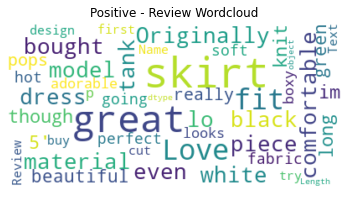

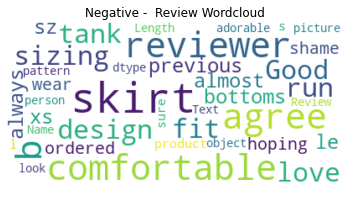

In [ ]:
df = df_sentiments.copy() 

positive_rev = df['Review Text'][df["sentiment_label"] == 'POSITIVE']
negative_rev = df['Review Text'][df["sentiment_label"] == 'NEGATIVE']

create_wordclouds(positive_rev, "Positive - Review Wordcloud")
create_wordclouds(negative_rev, "Negative -  Review Wordcloud")

**Take-away**: Neither this yield much insight. So the issue probably more on the text classification itself.

**Next step**: Try SpaCy library to generate word by word sentiment analysis and also try to only get the word cloud for the adjective only. 

## Keyword extraction : SpaCY

Use spacy (https://spacy.io/) to identify word types.

In [ ]:
! pip install spacy
! pip install spacytextblob
! python -m textblob.download_corpora
! python -m spacy download en_core_web_sm

In [ ]:
import spacy
from spacytextblob.spacytextblob import SpacyTextBlob

nlp = spacy.load("en_core_web_sm")
nlp.add_pipe("spacytextblob")

def get_sentiments(text_review):
  doc = nlp(text_review)
  sentiment = doc._.blob.polarity
  sentiment = round(sentiment,2)
  label = "NEGATIVE"
  label = "POSITIVE" if (sentiment > 0) else "NEGATIVE"

  positive_words = []
  negative_words = []
  adjective_words = []

  for word in doc._.blob.sentiment_assessments.assessments:
    if word[1] > 0:
      positive_words.append(word[0][0])
    elif word[1] < 0:
      negative_words.append(word[0][0])
    else:
      pass
  
  for token in doc:
    if token.pos_ == ("ADJ"):
      adjective_words.append(token)
  
  return label, sentiment, positive_words, negative_words, adjective_words

In [ ]:
dftest = df_sentiments.copy()
dftest.head()

,Unnamed: 0,Clothing ID,Review Text,Age,Rating,Recommended IND,Division Name,Department Name,Class Name,Positive Feedback Count,sentiment_dic,sentiment_label,sentiment_score
0,0,1,"I love this tank, it is so comfortable but it ...",24,2,0,Initmates,Intimate,Layering,1,"[{'label': 'NEGATIVE', 'score': 0.990729629993...",NEGATIVE,0.990730
1,1,1,Love this tank. material and fit are great. lo...,36,5,1,Initmates,Intimate,Layering,0,"[{'label': 'POSITIVE', 'score': 0.999883770942...",POSITIVE,0.999884
2,2,1,Originally i bought this in black and white. r...,50,5,1,Initmates,Intimate,Layering,0,"[{'label': 'POSITIVE', 'score': 0.999589979648...",POSITIVE,0.999590
3,3,10,This dress is comfortable and a great piece to...,38,4,1,Initmates,Intimate,Chemises,0,"[{'label': 'POSITIVE', 'score': 0.999801814556...",POSITIVE,0.999802
4,4,100,"Good design, comfortable fit. however, sizing ...",44,4,1,Initmates,Intimate,Intimates,3,"[{'label': 'NEGATIVE', 'score': 0.964921057224...",NEGATIVE,0.964921


In [ ]:
# 6mins runtime
dftest["spacy_analysis"] = [get_sentiments(rev) for rev in dftest["Review Text"]]
dftest["spacy_sentiment"] = [i[0] for i in dftest["spacy_analysis"]]
dftest["spacy_score"] = [i[1] for i in dftest["spacy_analysis"]]
dftest["spacy_pos"] = [i[2] for i in dftest["spacy_analysis"]]
dftest["spacy_neg"] = [i[3] for i in dftest["spacy_analysis"]]
dftest["spacy_adjective"] = [i[4] for i in dftest["spacy_analysis"]]

### Word cloud sentiment: Word based

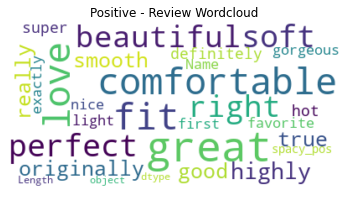

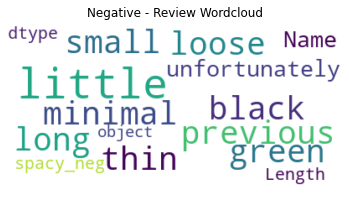

In [ ]:
positive_rev = dftest["spacy_pos"]
negative_rev = dftest["spacy_neg"]

create_wordclouds(positive_rev, "Positive - Review Wordcloud")
create_wordclouds(negative_rev, "Negative - Review Wordcloud")

### Word cloud sentiment: Sentence based

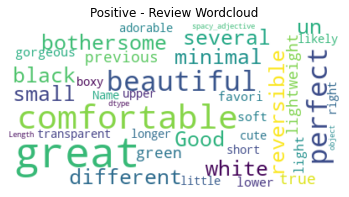

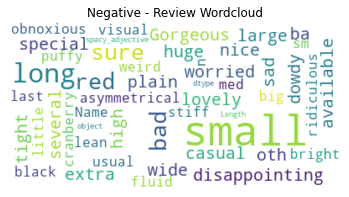

In [ ]:
positive_rev = dftest["spacy_adjective"][dftest["spacy_sentiment"] == 'POSITIVE']
negative_rev = dftest["spacy_adjective"][dftest["spacy_sentiment"] == 'NEGATIVE']

create_wordclouds(positive_rev, "Positive - Review Wordcloud")
create_wordclouds(negative_rev, "Negative - Review Wordcloud")

**Take-away**: Combination of both seems to indicate intuitively correct definition for both negative and positive. 

## Conclusion 
SpaCy seems to runs faster at 6 mins vs 50 mins (distillBERT) and seems to provide slightly more relevant words potentially because in one sentence, customer provides both positive and negative comments. Splitting them by word and classify pos and neg word might provide advantages to extract relevant outcome. 

**Potential Improvements** : Analysis by product type. Review by different word type (noun, adjective, verb). Tyr other sentence classification models. 
